# Feature Extraction for Real-Time Drone Sound Detection

This notebook focuses on preparing the audio dataset for drone sound detection. It performs the following key steps:

 - **Loading the audio data** from the dataset.

 - **Extracting MFCC features** from each audio file to use as input for the model.

 - **Applying data augmentation** on samples labeled as "drone" to improve model robustness:

     - Time stretching
    
     - Pitch shifting
    
     - Adding Gaussian noise
    
     - Scaling volume

 - **Saving the extracted features** in a compressed .npz file format for later use in the model development phase.

 - **Visualizing mel-spectrograms** for both drone and non-drone audio samples to better understand the data.

This step is essential for transforming raw audio into a structured format suitable for training a machine learning model.

In [3]:
# Importing Required Libraries

# Standard library
import os                                    # For handling file system paths and directory operations
import random                                # For introducing randomness (e.g., in data augmentation)
import warnings                              # To suppress unnecessary warnings

# Third-party libraries
import numpy as np                           # For numerical operations and working with arrays
import librosa                               # For audio processing (loading audio, extracting features, etc.)
import librosa.display                       # For visualizing audio data like waveforms and spectrograms
import matplotlib.pyplot as plt              # For plotting graphs and visualizing data
from collections import Counter              # For counting elements, e.g., label frequencies

# Suppress all warnings
warnings.filterwarnings('ignore')

In [4]:
# Setting paths to the drone and non-drone audio subdirectories
drone_path = "../data/drone"
non_drone_path = "../data/non_drone"

In [5]:
# The number of .wav files in each category
drone_files = [f for f in os.listdir(drone_path) if f.endswith(".wav")]
non_drone_files = [f for f in os.listdir(non_drone_path) if f.endswith(".wav")]

print(f"Number of raw audio files:\nDrone: {len(drone_files)}\nNon-Drone: {len(non_drone_files)}")

Number of raw audio files:
Drone: 1362
Non-Drone: 10906


## Feature Extraction & Dataset Preparation

In [7]:
# Setting audio processing parameters
SAMPLE_RATE = 16000       # Target sample rate for all audio files
N_MFCC = 13               # Number of MFCC features to extract
FRAME_LENGTH = 1          # Frame length in seconds for segmentation

In [8]:
# Extracting MFCC features from audio with optional data augmentation
def extract_features(file_path, sample_rate=SAMPLE_RATE, augment=False):
    """
    Extracts MFCC features from an audio file, optionally applying data augmentation.

    Args:
        file_path (str): Path to the audio file.
        sample_rate (int): Target sample rate for loading the audio.
        augment (bool): Whether to apply data augmentation techniques.

    Returns:
        List[np.ndarray]: A list of 2D MFCC feature arrays (time_steps, n_mfcc).
    """
    y, sr = librosa.load(file_path, sr=sample_rate)
    segment_length = sample_rate * FRAME_LENGTH
    segments = []

    def get_mfcc(segment):
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=N_MFCC)
        return mfcc.T  # Transposing to shape (time_steps, n_mfcc)

    # Splitting the audio into 1-second segments and extracting MFCCs
    for i in range(0, len(y), segment_length):
        segment = y[i:i + segment_length]
        if len(segment) < segment_length:
            continue
        segments.append(get_mfcc(segment))

        if augment:
            # Applying time stretching
            stretched = librosa.effects.time_stretch(segment, rate=np.random.uniform(0.8, 1.2))
            if len(stretched) >= segment_length:
                segments.append(get_mfcc(stretched[:segment_length]))

            # Applying pitch shifting
            pitched = librosa.effects.pitch_shift(segment, sr=sr, n_steps=np.random.randint(-2, 3))
            segments.append(get_mfcc(pitched))

            # Adding Gaussian noise
            noise = 0.005 * np.random.randn(len(segment))
            noisy = segment + noise
            segments.append(get_mfcc(noisy))

            # Scaling volume
            scaled = segment * np.random.uniform(0.7, 1.3)
            segments.append(get_mfcc(scaled))

    return segments

In [9]:
# Loading data from both drone and non-drone folders, extracting features and labels
def load_data(drone_path, non_drone_path):
    """
    Loads audio files from drone and non-drone directories, applies feature extraction,
    and returns features and labels.

    Args:
        drone_path (str): Path to the directory containing drone audio files.
        non_drone_path (str): Path to the directory containing non-drone audio files.

    Returns:
        X (List[np.ndarray]): List of MFCC feature arrays.
        y (List[int]): Corresponding list of labels (1 for drone, 0 for non-drone).
    """
    X, y = [], []

    # Processing drone audio files with augmentation
    for file in os.listdir(drone_path):
        if file.endswith(".wav"):
            features = extract_features(os.path.join(drone_path, file), augment=True)
            X.extend(features)
            y.extend([1] * len(features))
            assert len(X) == len(y), f"Mismatch after {file}"

    # Processing non-drone audio files without augmentation
    for file in os.listdir(non_drone_path):
        if file.endswith(".wav"):
            features = extract_features(os.path.join(non_drone_path, file), augment=False)
            X.extend(features)
            y.extend([0] * len(features))

    return X, y

In [10]:
# Loading the dataset
X, y = load_data(drone_path, non_drone_path)

In [11]:
# Counting and printing the number of samples for each label (1 = Drone, 0 = Non-Drone)
label_counts = Counter(y)
print(f"Label Distribution:\nDrone: {label_counts[1]}\nNon-Drone: {label_counts[0]}")

Label Distribution:
Drone: 6233
Non-Drone: 8867


In [12]:
# Converting X (list of 2D arrays) to an object array
X_array = np.array(X, dtype=object)
y_array = np.array(y)

# Saving to file
np.savez_compressed("audio_features.npz", X=X_array, y=y_array)

## Visualizing Sample Mel-Spectrograms

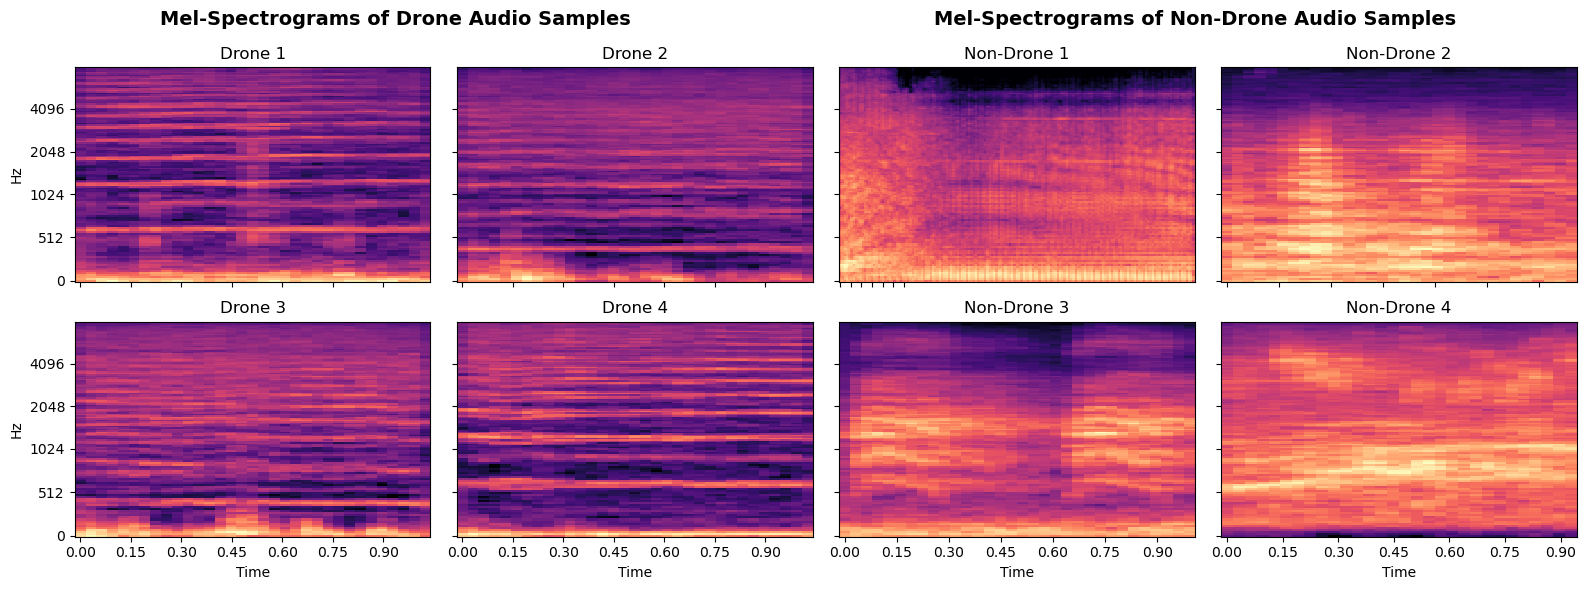

In [14]:
# Setting random seed for reproducibility
random.seed(42)

# Randomly selecting 4 files from each class
sample_drone_files = random.sample(drone_files, 4)
sample_non_drone_files = random.sample(non_drone_files, 4)

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
fig.patch.set_facecolor('white')

# Defining time tick positions and labels
time_ticks = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
time_labels = [f"{t:.2f}" for t in time_ticks]

# Plotting Drone Samples
for idx, file_path in enumerate(sample_drone_files):
    y, sr = librosa.load(os.path.join(drone_path, file_path), sr=SAMPLE_RATE)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    ax = axes[idx // 2][idx % 2]
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f"Drone {idx+1}")
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    ax.label_outer()

# Plotting Non-Drone Samples
for idx, file_path in enumerate(sample_non_drone_files):
    y, sr = librosa.load(os.path.join(non_drone_path, file_path), sr=SAMPLE_RATE)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    ax = axes[idx // 2][(idx % 2) + 2]
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    ax.set_title(f"Non-Drone {idx+1}")
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    ax.label_outer()

# Adding group titles
fig.text(0.25, 0.95, "Mel-Spectrograms of Drone Audio Samples", ha='center', fontsize=14, weight='bold')
fig.text(0.75, 0.95, "Mel-Spectrograms of Non-Drone Audio Samples", ha='center', fontsize=14, weight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()